In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
chronic_kidney_disease = fetch_ucirepo(id=336) 
  
# data (as pandas dataframes) 
X = chronic_kidney_disease.data.features 
y = chronic_kidney_disease.data.targets 
  
# variable information 
print(chronic_kidney_disease.variables) 

     name     role         type demographic              description  \
0     age  Feature      Integer         Age                     None   
1      bp  Feature      Integer        None           blood pressure   
2      sg  Feature  Categorical        None         specific gravity   
3      al  Feature  Categorical        None                  albumin   
4      su  Feature  Categorical        None                    sugar   
5     rbc  Feature       Binary        None          red blood cells   
6      pc  Feature       Binary        None                 pus cell   
7     pcc  Feature       Binary        None          pus cell clumps   
8      ba  Feature       Binary        None                 bacteria   
9     bgr  Feature      Integer        None     blood glucose random   
10     bu  Feature      Integer        None               blood urea   
11     sc  Feature   Continuous        None         serum creatinine   
12    sod  Feature      Integer        None                   so

1. Use physical features to predict whether patients have  chronic kidney disease(ckd).

2. Convert categories to numerical categories. The variable `dm` contains an uncommon value of '\tno', which should be corrected to 'no'.

In [4]:
X.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,11.3,38.0,6000.0,NaN,no,no,no,good,no,no
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,11.6,35.0,7300.0,4.6,no,no,no,good,no,no


In [5]:
num = X.select_dtypes(include='float').columns 
cat = X.select_dtypes(include='object').columns 
print(cat)
X['dm'] = X['dm'].str.replace('\t', '')
y['class'] = y['class'].str.replace('\t', '')
data = pd.concat([X,y],axis=1)
for col in cat:
    data[col] = pd.Categorical(data[col]).codes
data = data.replace(-1, np.nan)
data.head()

Index(['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'], dtype='object')


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,1.0,0.0,0.0,121.0,...,44.0,7800.0,5.2,1.0,1.0,0.0,0.0,0.0,0.0,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,1.0,0.0,0.0,NaN,...,38.0,6000.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,ckd
2,62.0,80.0,1.010,2.0,3.0,1.0,1.0,0.0,0.0,423.0,...,31.0,7500.0,NaN,0.0,1.0,0.0,1.0,0.0,1.0,ckd
3,48.0,70.0,1.005,4.0,0.0,1.0,0.0,1.0,0.0,117.0,...,32.0,6700.0,3.9,1.0,0.0,0.0,1.0,1.0,1.0,ckd
4,51.0,80.0,1.010,2.0,0.0,1.0,1.0,0.0,0.0,106.0,...,35.0,7300.0,4.6,0.0,0.0,0.0,0.0,0.0,0.0,ckd


3. There are 400 observations in the dataset with 24 features. Some features are categorical variables such as `rbc`, `pc`, `pcc` which are of `object` type while others are numerical varibales which are of `float` type. All features have missing values, for example, `bp` have 388 non-null values.

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    object 
 22  pe

The patients' ages span from 2 to 90 years. A significant majority, over 75% of observations, have an `al` of 0, although the maximum recorded value is 5, which could be considered an outlier. In contrast, `sg` exhibits the least variability among the variables studied.

In [7]:
X.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


The variable `ba` is highly imbalanced, with only 22 out of 396 observations present for this feature. 250 out of 400 patients have ckd.

In [8]:
for col in cat:
    print(X[col].value_counts())
print(y.value_counts())

normal      201
abnormal     47
Name: rbc, dtype: int64
normal      259
abnormal     76
Name: pc, dtype: int64
notpresent    354
present        42
Name: pcc, dtype: int64
notpresent    374
present        22
Name: ba, dtype: int64
no     251
yes    147
Name: htn, dtype: int64
no     261
yes    137
Name: dm, dtype: int64
no     364
yes     34
Name: cad, dtype: int64
good    317
poor     82
Name: appet, dtype: int64
no     323
yes     76
Name: pe, dtype: int64
no     339
yes     60
Name: ane, dtype: int64
class 
ckd       250
notckd    150
dtype: int64


4. For the selected numerical variables, notable disparities exist between the means of the two groups. For instance, individuals with chronic kidney disease (CKD) tend to be older and exhibit higher blood pressure compared to those without CKD.

In [9]:
data.groupby('class').agg(
    age=('age', 'mean'),
    bp=('bp', 'mean'),
    al=('al', 'mean'),
    bu=('bu', 'mean'),
    wbcc=('wbcc', 'mean'),
    rbcc=('rbcc', 'mean'),
    count=('class', 'count'),
)

,age,bp,al,bu,wbcc,rbcc,count
class,,,,,,,
ckd,54.541322,79.625000,1.722488,72.389030,9069.536424,3.945238,250
notckd,46.516779,71.351351,0.000000,32.798611,7705.594406,5.379021,150


For patients without ckd, all categorical variables exhibit only one value. For instance, the `rbc` variable for these patients is exclusively 'normal'.

In [10]:
data.groupby('class').agg(
    rbc=('rbc', 'mean'),
    pc=('pc', 'mean'),
    pcc=('pcc', 'mean'),
    ba=('ba', 'mean'),
    htn=('htn', 'mean'),
    dm=('dm', 'mean'),
    cad=('cad', 'mean'),
    appet=('appet', 'mean'),
    pe=('pe', 'mean'),
    ane=('ane', 'mean'),
    count=('class', 'count'),
)

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane,count
class,,,,,,,,,,,
ckd,0.560748,0.608247,0.168,0.088,0.588,0.548,0.136,0.328,0.304,0.24,250
notckd,1.000000,1.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,150


5. Drop all rows with missing values.

In [11]:
data_clean = data.dropna().reset_index(drop=True)
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     158 non-null    float64
 1   bp      158 non-null    float64
 2   sg      158 non-null    float64
 3   al      158 non-null    float64
 4   su      158 non-null    float64
 5   rbc     158 non-null    float64
 6   pc      158 non-null    float64
 7   pcc     158 non-null    float64
 8   ba      158 non-null    float64
 9   bgr     158 non-null    float64
 10  bu      158 non-null    float64
 11  sc      158 non-null    float64
 12  sod     158 non-null    float64
 13  pot     158 non-null    float64
 14  hemo    158 non-null    float64
 15  pcv     158 non-null    float64
 16  wbcc    158 non-null    float64
 17  rbcc    158 non-null    float64
 18  htn     158 non-null    float64
 19  dm      158 non-null    float64
 20  cad     158 non-null    float64
 21  appet   158 non-null    float64
 22  pe

6. 

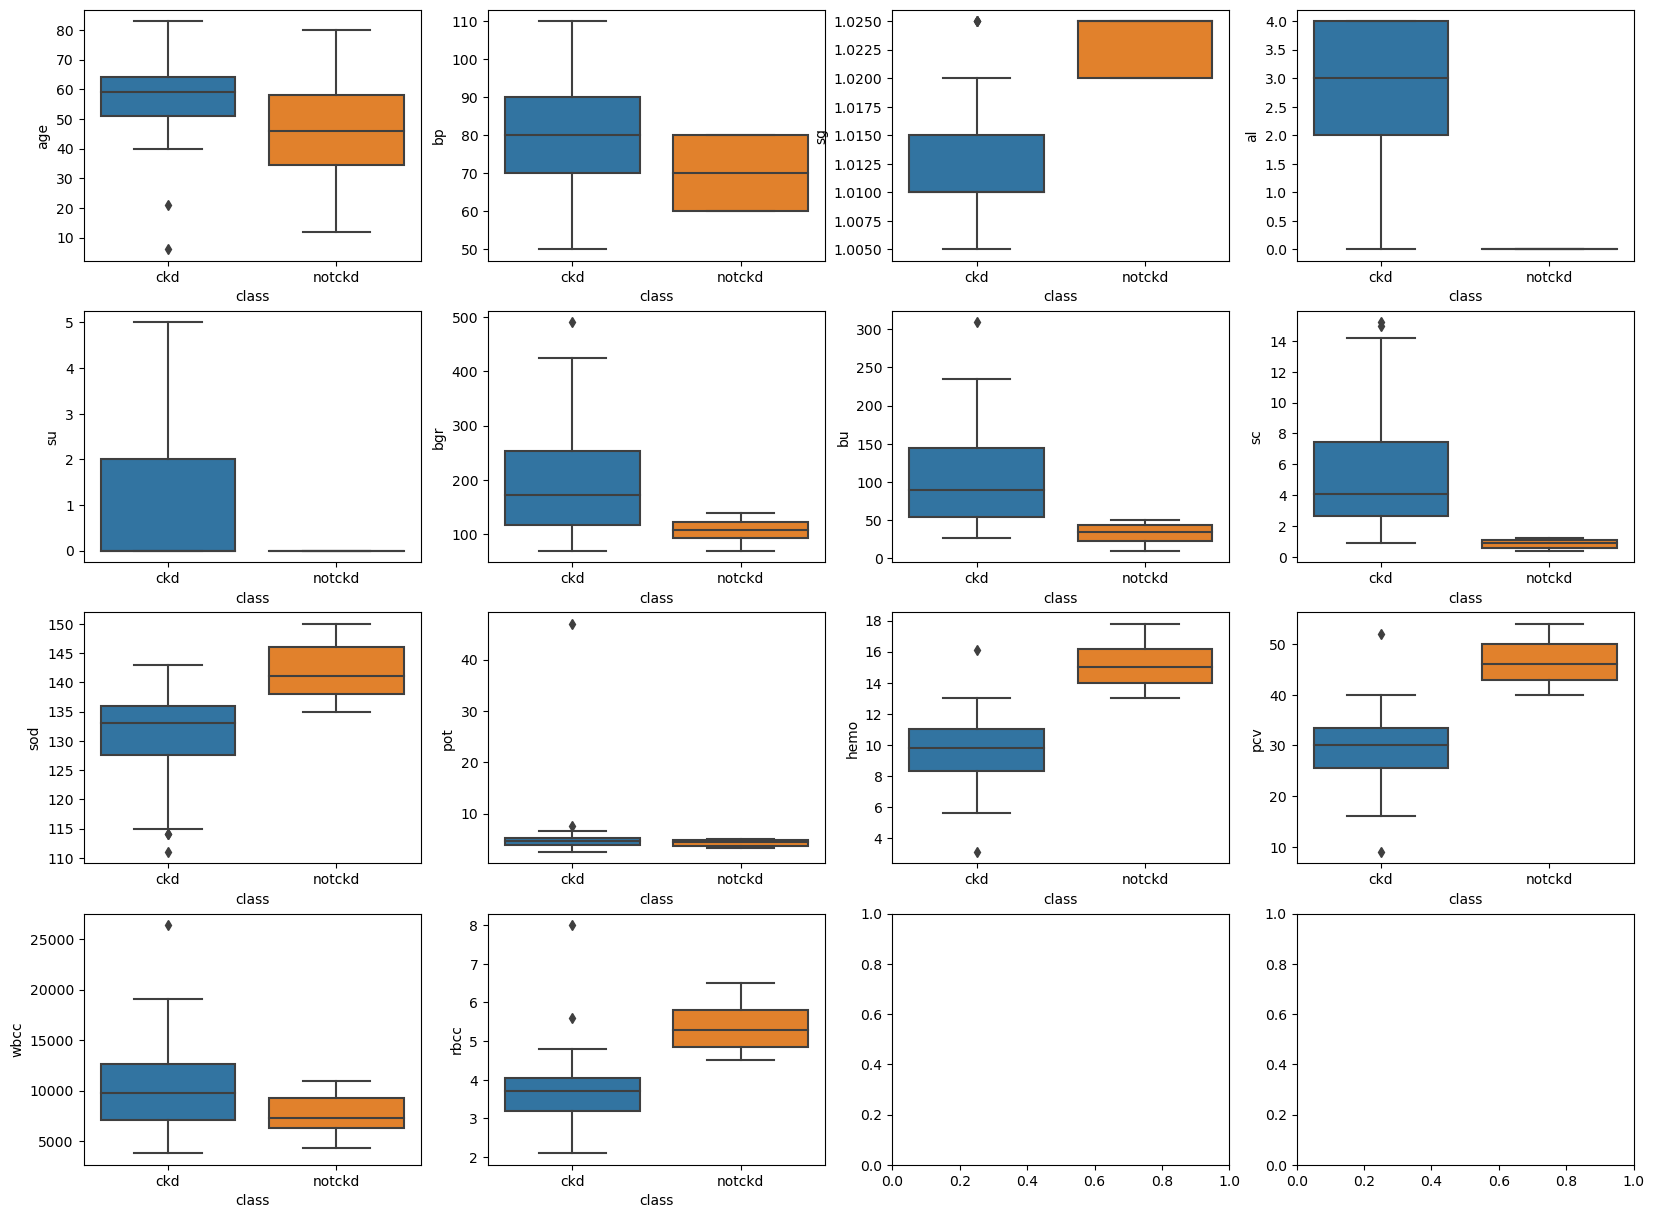

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
for i, col in enumerate(num):
    sns.boxplot(x='class', y=col, data=data_clean, ax=axes[i//4, i%4])
plt.show()

In [13]:
data_clean = data_clean[(data_clean['age']>20)|(data_clean['class']=='notckd')]
data_clean = data_clean[data_clean['bgr']<400]
data_clean = data_clean[data_clean['bu']<250]
data_clean = data_clean[data_clean['pot']<20]
data_clean = data_clean[data_clean['wbcc']<20000]
data_clean = data_clean[data_clean['rbcc']<7]
data_clean.shape

(151, 25)

7. Let `htn=1` and `ba`=0 be the group that is more likey to be ckd.

In [14]:
data_clean.groupby('class').agg(
    rbc=('rbc', 'mean'),
    pc=('pc', 'mean'),
    pcc=('pcc', 'mean'),
    ba=('ba', 'mean'),
    htn=('htn', 'mean'),
    dm=('dm', 'mean'),
    cad=('cad', 'mean'),
    appet=('appet', 'mean'),
    pe=('pe', 'mean'),
    ane=('ane', 'mean'),
    count=('class', 'count'),
)

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane,count
class,,,,,,,,,,,
ckd,0.583333,0.305556,0.361111,0.277778,0.777778,0.638889,0.277778,0.444444,0.5,0.388889,36
notckd,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,115


<AxesSubplot:xlabel='class', ylabel='count'>

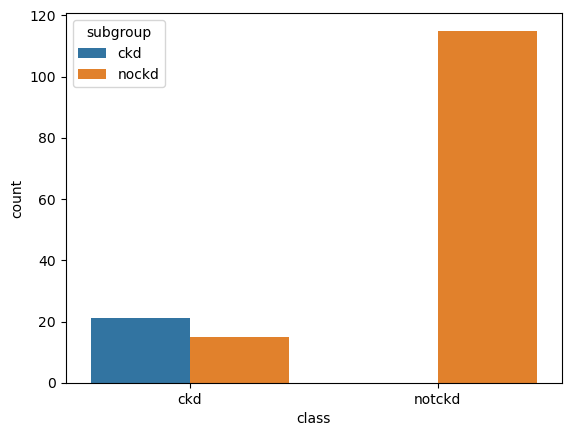

In [15]:
data_clean['subgroup'] = np.where((data_clean['htn'] == 1) & (data_clean['ba'] == 0), 'ckd', 'nockd')
sns.countplot(
    data=data_clean,
    x = 'class',
    hue = 'subgroup'
)

8.

In [16]:
X0 = data_clean.drop(['class', 'subgroup'], axis=1)
y0 = data_clean['class']
X_train, X_test, y_train, y_test = train_test_split(
    X0, y0, test_size=0.3, random_state=1, stratify=y0)

9. Logistic_regression and Decision Tree.

10. Accuracy and F1-score.

11. The decision tree can correctly classified all observations using only one feature `al`.

[Text(0.5, 0.75, 'al <= 0.5\ngini = 0.363\nsamples = 105\nvalue = [25, 80]\nclass = notckd'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 80\nvalue = [0, 80]\nclass = notckd'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 25\nvalue = [25, 0]\nclass = ckd')]

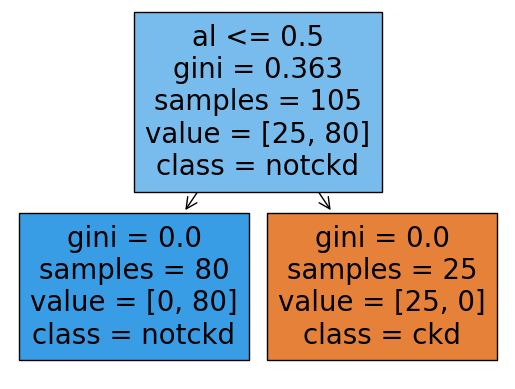

In [17]:
ckd_dt = DecisionTreeClassifier(
    max_depth = 10, 
    random_state=0
)
ckd_dt.fit(X_train, y_train)
plot_tree(
    ckd_dt, 
    max_depth= 2, 
    feature_names = X_train.columns.tolist(), 
    class_names=['ckd', 'notckd'], 
    filled = True
    )

12. While the Logistic Regression model successfully classifies all observations in the test set, the Decision Tree model has one misclassification. Thus, the Logistic Regression model exhibits higher F1-score and accuracy compared to the Decision Tree model. It's noteworthy that all observations belonging to the notckd group are correctly classified by both models.

In [18]:
ckd_dt_best = DecisionTreeClassifier(
    max_depth = 1, 
    random_state=0
    ) 
ckd_dt_best.fit(X_train, y_train)
ckd_dt_pred = ckd_dt_best.predict(X_test)
dt_cm = pd.DataFrame(confusion_matrix(y_test, ckd_dt_pred), index=['ckd', 'notckd'], columns=['ckd', 'notckd'])
dt_cm.index.name = 'True'
dt_cm.columns.name = 'Predicted'
dt_cm

Predicted,ckd,notckd
True,,
ckd,10,1
notckd,0,35


In [19]:
print(classification_report(y_test, ckd_dt_pred))

              precision    recall  f1-score   support

         ckd       1.00      0.91      0.95        11
      notckd       0.97      1.00      0.99        35

    accuracy                           0.98        46
   macro avg       0.99      0.95      0.97        46
weighted avg       0.98      0.98      0.98        46



In [20]:
ckd_log = LogisticRegression(max_iter=500)
ckd_log.fit(X_train, y_train)
pred_prob = ckd_log.predict_proba(X_test)
ckd_log_pred = np.where(pred_prob[:,1]>0.5, 'notckd', 'ckd')
log_cm = pd.DataFrame(confusion_matrix(y_test, ckd_log_pred), index=['ckd', 'notckd'], columns=['ckd', 'notckd'])
log_cm.index.name = 'True'
log_cm.columns.name = 'Predicted'
log_cm

Predicted,ckd,notckd
True,,
ckd,11,0
notckd,0,35


In [21]:
print(classification_report(y_test, ckd_log_pred))

              precision    recall  f1-score   support

         ckd       1.00      1.00      1.00        11
      notckd       1.00      1.00      1.00        35

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46



13. The Decision Tree model consistently classifies all patients with `al`>0.5 as 'ckd', aligning with the negative coefficient observed in logistic regression. Despite `al` is of a smaller scale compared to other variables, its coefficient in logistic regression is relatively large, indicating its significant impact on the classification outcome.

[Text(0.5, 0.75, 'al <= 0.5\ngini = 0.363\nsamples = 105\nvalue = [25, 80]\nclass = notckd'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 80\nvalue = [0, 80]\nclass = notckd'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 25\nvalue = [25, 0]\nclass = ckd')]

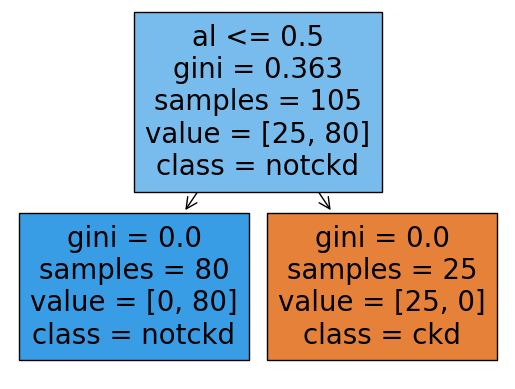

In [22]:
plot_tree(
    ckd_dt_best, 
    max_depth= 1, 
    feature_names = X_train.columns.tolist(), 
    class_names=['ckd', 'notckd'], 
    filled = True
    )

In [231]:
pd.DataFrame({'Feature': X_train.columns, 'Coefficient': ckd_log.coef_[0]})

,Feature,Coefficient
0,age,-0.148653
1,bp,0.008049
2,sg,-0.009486
3,al,-0.578377
4,su,-0.003746
5,rbc,0.008783
6,pc,0.171232
7,pcc,-0.003029
8,ba,-0.010876
9,bgr,-0.168963
